# Goal of this python notebook

In this python notebook, we see that a DL model is able to predict which local coordinate transfromation is applied in the spacetime. We consider the
following coordinate transformation of the BH asymptotic isometry:
$$ \begin{align}
\bar{t}&= \frac{1}{2\lambda} (\lambda t + \phi) + \frac{1}{2 \lambda} F(\lambda t- \phi) + \frac{1}{4 \lambda^3 r^2} F^{\prime \prime}(\lambda t -\phi), \\
\bar{r} &= \frac{r}{\sqrt{F^{\prime}(\lambda t -\phi)}}, \\
\bar{\phi} &= \frac{1}{2} (\lambda t + \phi) - \frac{1}{2 } F(\lambda t- \phi) + \frac{1}{4 \lambda^2 r^2} F^{\prime \prime}(\lambda t -\phi),
\end{align} $$
where $F ( \sigma ) = \sigma +a \sin \sigma$.
In the simulation, $a$ is characterized by 0.1, 0.2, 0.3 and 0.4.
A DL model predicts $a$ from $(\bar{r},\bar{\phi})$ images of geodesics. 

# Import library

We first import some libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Reshape
from keras.layers.convolutional import  Conv2D
from keras.layers.pooling import  MaxPooling2D
from keras.utils import np_utils

# Mounting the google drive

To save the dataset we will generate, we utilize the google drive in this notebook. So we have to mount the google drive.

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Generate data

We first generate numpy arrays in which geodesics before the coordinate transformation are saved using the solution of the equation of motion of free particles in 2+1 AdS:
$$ r = \frac{1}{λ} \sqrt{E - \sqrt{E^2 - λ^2 L^2} \sin2 λ \tau},$$
$$\phi = \pm \arctan \left[  \frac{E}{\lambda L} \left( \tan λ \tau - \sqrt{1 - \left( \frac{λ L }{E}\right)^2} \right)\right] + \phi_0, $$
$$ t = \frac{1}{\lambda} \arctan \left[ \frac{(1+E)\tanλ\tau - \sqrt{E^2 - λ^2 L^2}}{\sqrt{1+2E+λ^2 L^2}} \right] + t_0 ,$$
where $E$  is a positive constant associated with energy, $L$ is a real constant associated with angular momentum, and
$t_0$ $(ϕ_0)$ is an integration constant for $t (ϕ )$. In this simulation, $\lambda$ is fixed to be 1.

We generate $E$, $L$, $t_0$ and $\phi_0$ at random. We set the range of them to 
$ 0 \leq E < 0.25 $, $0 \leq L < \frac{E}{λ}$ , $ 0 \leq \phi_0 <2 \pi$ and $ 0 \leq t_0 <2 \pi$. 


In [3]:
def generate_3d_initial_state(num_particle,lambda0):
  # num_particle means the number of particles/trajectories in one image.
  # lambda0 is the parameter which is associated with the curvature of AdS. 

  E_rand = np.random.rand(num_particle)*0.25 # E_rand represents E.
  L_rand =  np.random.rand(num_particle)* E_rand / lambda0 # L_rand represents L.
  phi_rand = np.random.rand(num_particle)* 2 *np.pi #phi_rand represents \phi_0.
  time_rand = np.random.rand(num_particle)* 2 * np.pi #time_rand represents t_0.

  return E_rand,L_rand,phi_rand,time_rand

Because the solution of $t$ contains $\arctan$ and it is not a single-valued function, we define a function to calculate the solution of $t$.

In [4]:
def time_arctan(t,E,L,lambda0):
  # In the code, "t" represents the proper time and "time" means the coordinate time.
  
  #calculating coordinate time  
  X = (lambda0 ** 2) * (L ** 2)
  time = 1 / lambda0 * np.arctan( ((1 + E ) * np.tan(lambda0 * t) - np.sqrt(E ** 2  - X )  )/ np.sqrt( 2 * E + X + 1 )  )  + 1/lambda0 * np.floor( (lambda0 * t + (np.pi / 2))/ np.pi ) * np.pi
  return time

We calculate the geodesic of one particle using the solution of the equation of motion. 

In [5]:
def time_evolve_3d(t,E,L,lambda0,phi0,time0):
  # time0 and phi0 are the initial values of coordinate time and \phi.
    
  r = 1 / lambda0 *  np.sqrt(E - np.sqrt(E ** 2 - (lambda0 ** 2) * (L ** 2) ) * np.sin(2 * lambda0 * t) )
  Y = E * (np.sin(lambda0 * t) - np.sqrt(1- (lambda0 * L / E)**2 )* np.cos(lambda0 * t) )
  X = lambda0 * L * np.cos(lambda0 * t)

  phi = np.arctan2(Y,X) + phi0
  time = time_arctan(t,E,L,lambda0) + time0

  return r,phi,time

We make numpy arrays which are utilized to get one image before the coordinate transformation.

In [6]:
def generate_one_3d_rawdata(num_particle,lambda0):

  delta_tau = 0.005 #delta_tau represents the slice of \tau.

  # Because \tau is the argument of trigonometric functions sin(2 \lambda \tau) and tan(\lambda \tau), we can set the range of $\tau$ to $ 0 \leq \tau < 2\pi.
  # tau_frame is the number of frames.
  tau_frame = int(np.ceil(2 * np.pi / delta_tau))

  E_rand, L_rand,phi_rand,time_rand = generate_3d_initial_state(num_particle,lambda0)

  #\phi has a freedom of sign and we assign the sign by binomial random variables. 
  sign_phi = np.random.binomial(1,0.5,size=num_particle)

  # preparing an array to store the information of the particles 
  raw_data_array = np.zeros([num_particle,3,tau_frame])

  for i in range(0,tau_frame): 
      # i is the counter for the frame number.
      for j in range(num_particle):
        # j is the counter for the particle number.
        r, phi, time = time_evolve_3d(i * delta_tau, E_rand[j],L_rand[j],lambda0,phi_rand[j],time_rand[j])
        raw_data_array[j,0,i] = r
        raw_data_array[j,1,i] = phi * ( (-1) ** sign_phi[j] )
        raw_data_array[j,2,i] = time 

  return raw_data_array

Next, we define a function which returns coordinates after the coordinate transformation.

In [7]:
def local_transform(raw_data_array,lambda0,a):
  #raw_data_array is the array returned by generate_one_3d_rawdata.

  # preparing another new array to store the information of the particles after the transformation.
  new_data_array = np.zeros_like(raw_data_array)

  num_particle = new_data_array.shape[0]
  tau_frame = new_data_array.shape[2]

  for i in range(0,tau_frame): 
      for j in range(num_particle):
        # r, phi,time are coordinate before the transformation
        r = raw_data_array[j,0,i] 
        phi = raw_data_array[j,1,i] 
        time = raw_data_array[j,2,i] 

        z_p = lambda0 * time + phi #z_p means $\lambda t + \phi
        z_m = lambda0 * time  - phi #z_m means $\lambda t - \phi

        F = z_m  + a * np.sin(z_m) # F is the function which charcterizes the coordinate transformation
        dF = 1 + a * np.cos(z_m) #dF is the derivative of F
        ddF = -1 * a * np.sin(z_m) # ddF is the second derivative of F

        temp_r = r / np.sqrt(dF) #r_new
        new_data_array[j,0,i] = temp_r 
        temp_phi = 1/2 * z_p -1/2 * F + 1/ ( 4 * (lambda0 ** 2) * (r ** 2) ) * ddF #phi_new
        new_data_array[j,1,i] = np.mod(temp_phi,2*np.pi)
        new_data_array[j,2,i] = 1/ ( 2 * lambda0) * z_p + 1/ ( 2 * lambda0) * F + 1/ (4 * (lambda0 ** 3) * (r**2))*ddF #time_new 

  return new_data_array

We also define a function which returns an array which saves the geodesics after the transformation and $a$ which is the parameter that characterizes the coordinate transformation.

In [8]:
def generate_one_localtransformed_3d_data(num_particle,lambda0):

  raw_data_array = generate_one_3d_rawdata(num_particle,lambda0) #array which saves the information of the particles before the transformation
  a = np.random.randint(1,5) * 0.1  #a is chosen from 0.1,0.2,0.3 and 0.4 at random 
  transformed_data_array = local_transform(raw_data_array,lambda0,a) #array which saves the information of the particles after the transformation
  return transformed_data_array,a                              

We define a function which generates a dateset.

In [9]:
def generate_dataset(num_data,num_particle,lambda0):

  # we prepare two variables data_x and data_y.
  # data_x contains the solution of EOM after the coordinate transformation. 
  # data_y contains the values of a.
  data_x = []
  data_y = []

  for i in range(num_data):
    x,y = generate_one_localtransformed_3d_data(num_particle,lambda0)
    data_x.append(x)
    data_y.append(y)

  data_x = np.array(data_x) #[data_number,particle_number,coordinate,proper_time]
  data_y = np.array(data_y)

  return data_x,data_y

We generate a dataset using functions defined above. 

In [10]:
#setting parameters
lambda0 = 1
num_particle = 25
num_data = 4000

# generating dataset as numpy array
data_x, data_y = generate_dataset(num_data,num_particle,lambda0)

In [11]:
# saving the data in npz file
# replacing the file path accodring to your coding environment.
file_path = "/content/drive/My Drive/Colab Notebooks/metric_detecter_public"
# You can replace the  "/dataset_bhcharge" to your favorite name of npz file.
np.savez_compressed(file_path + '/dataset_bhcharge', data_x,data_y)

# Printing some images and Preprocessing

In this section, we perform some preprocessing and print some $(\bar{r},\bar{\phi})$ images.

In [12]:
# reloading the data from npz file
# replacing the file path accodring to your coding environment.
file_path = "/content/drive/My Drive/Colab Notebooks/metric_detecter_public"
dataset_array = np.load(file_path + '/dataset_bhcharge.npz')
data_x = dataset_array["arr_0"]
data_y = dataset_array["arr_1"]

We define a function which make  $(\bar{r},\bar{\phi})$ images.

In [13]:
def numpyarray_r_phi_image(r_array,phi_array):
  #r_arry  and phi_array represent \bar{r} and \bar{\phi}, respectively.

  # setting the number of pixels in a image.
  pixel_num = 200
  num_data = len(r_array)

  # obtaining the maximum value and the minimum value of \bar{r} and \bar{\phi} to decide the resolution of images
  r_max = np.max(r_array)
  r_min = np.min(r_array)
  h = r_max - r_min + 0.01

  phi_max = np.max(phi_array)
  phi_min = np.min(phi_array)
  w = phi_max - phi_min + 0.01

  # delta_x and delta_y represent slices of images.
  delta_y = h/pixel_num 
  delta_x = w / pixel_num  

  xy_image = np.zeros([num_data,pixel_num, pixel_num,1])
  for i in range(num_data):
    temp_x = phi_array[i,:,:].reshape(-1)
    temp_y = r_array[i,:,:].reshape(-1)

    # discretizing \bar{r} and \bar{phi} by delta_x and delta_y
    for x,y in zip(temp_x,temp_y):
      xy_image[i,int(np.floor((x - phi_min)/delta_x)), int(np.floor((y - r_min)/delta_y)),0] = 1

  return xy_image

We generate $(\bar{r},\bar{\phi})$ images from the function defined above.

In [15]:
# extracting \bar{r} values  from data_x
r_array = data_x[:,:,0,:]
# extracting \bar{phi} values from data_x
phi_array = data_x[:,:,1,:]
# generating (\bar{r},\bar{\phi}) images
image_data = numpyarray_r_phi_image(r_array,phi_array)

Let's print some images.

value of a: 0.30000000000000004


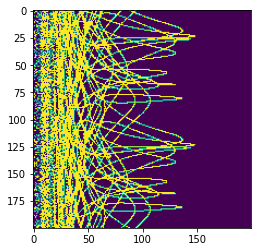

value of a: 0.30000000000000004


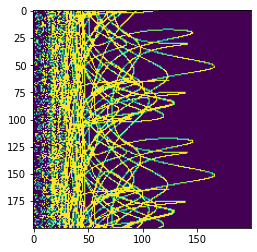

value of a: 0.30000000000000004


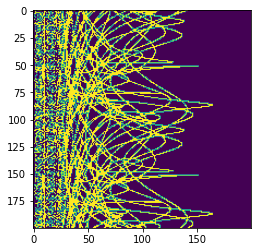

value of a: 0.2


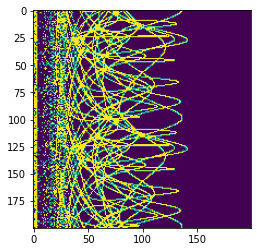

value of a: 0.4


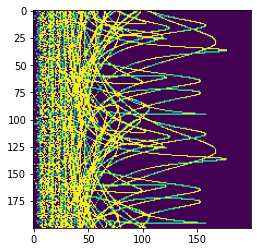

In [16]:
for i in range(5):
  plt.imshow(image_data[i,:,:,0])
  
  print("value of a:",data_y[i])
  plt.show()

We split dataset into training data, validation data and test data.

In [17]:
num_data = len(r_array) # we set it  to 4000.
# We generate 2800 training data, 800 validation data and 400 test data.
train_index = int(0.7*num_data)
vali_index = int(0.9 *num_data)

# We convert data_y to one-hot vectors.
y_temp = np.floor(data_y * 10) - 1
y_temp = y_temp.astype("int64")
y_one_hot = np_utils.to_categorical(y_temp)

x_train = image_data[:train_index,:,:,:]
y_train = y_one_hot[:train_index]
x_vali = image_data[train_index:vali_index,:,:,:]
y_vali = y_one_hot[train_index:vali_index]
x_test = image_data[vali_index:,:,:,:]
y_test = y_one_hot[vali_index:]

# Training a DL model

Here, we train a DL model.  We use CNN. It's structure is the following.

In [18]:
input_shape = image_data[0,:,:,:].shape
model = Sequential()
model.add(Conv2D(5, (5,5), strides=(1, 1), input_shape=input_shape,padding='same', dilation_rate=(1, 1),activation='tanh', use_bias=True))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model.add(Conv2D(5, (3,3), strides=(1, 1),padding='same',activation='tanh', use_bias=True))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
model.add(Conv2D(3, (3,3), strides=(1, 1),padding='same',activation='tanh', use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(2, (2,2), strides=(1, 1),padding='same',activation='tanh', use_bias=True))
model.add(Flatten())
model.add(Dense(10,activation='tanh'))
model.add(Dense(10,activation='tanh'))
model.add(Dense(4,activation='softmax')) # 4 classes
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 5)       130       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 67, 67, 5)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 67, 5)         230       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 5)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 3)         138       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 3)        0

The loss function of this task is the categorical crossentropy and we use ADAM as a optimizer. We train the model for 150 epochs.

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=50,
                    epochs=150,
                    verbose=1,
                    validation_data=(x_vali, y_vali))
score = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/150
56/56 [==============================] - 12s 20ms/step - loss: 1.3837 - accuracy: 0.2632 - val_loss: 1.3607 - val_accuracy: 0.3175
Epoch 2/150
56/56 [==============================] - 1s 11ms/step - loss: 1.2745 - accuracy: 0.3954 - val_loss: 1.1364 - val_accuracy: 0.4500
Epoch 3/150
56/56 [==============================] - 1s 12ms/step - loss: 0.9539 - accuracy: 0.5929 - val_loss: 0.7688 - val_accuracy: 0.7038
Epoch 4/150
56/56 [==============================] - 1s 11ms/step - loss: 0.6555 - accuracy: 0.7539 - val_loss: 0.5576 - val_accuracy: 0.8000
Epoch 5/150
56/56 [==============================] - 1s 12ms/step - loss: 0.5001 - accuracy: 0.8250 - val_loss: 0.4474 - val_accuracy: 0.8375
Epoch 6/150
56/56 [==============================] - 1s 11ms/step - loss: 0.4057 - accuracy: 0.8639 - val_loss: 0.3817 - val_accuracy: 0.8662
Epoch 7/150
56/56 [==============================] - 1s 12ms/step - loss: 0.3579 - accuracy: 0.8746 - val_loss: 0.3333 - val_accuracy: 0.8900
Epoch

We check the value of the loss function for test data and plot how loss functions for training data and validation data change as the model learnes.

The loss function for test data: 0.526736855506897


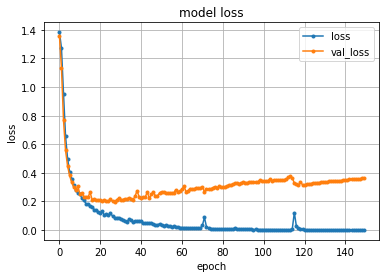

In [20]:
print('The loss function for test data:', score[0])
plt.plot(history.history['loss'], marker='.', label='loss')
plt.plot(history.history['val_loss'], marker='.', label='val_loss')
plt.title('model loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

We also check how the model accuracy varies.

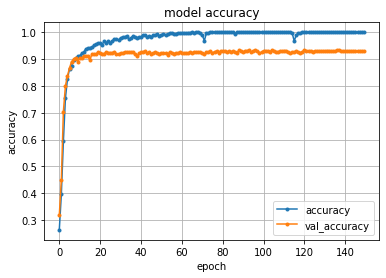

In [21]:
plt.plot(history.history['accuracy'], marker='.', label='accuracy')
plt.plot(history.history['val_accuracy'], marker='.', label='val_accuracy')
plt.title('model accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

We see the model accuracy for test data. 

In [22]:
print('The accuracy for test data:', score[1])

The accuracy for test data: 0.9100000262260437


Let's print some results of the predicting of DL. The title of each image shows the prediction and the blue (red) color of the title means the correct (incorrect) prediction. There is a about 85 % chance that DL returns correct answers. DL can predict which coordinate transformation is applied. However, compared to other three task regarding predictig the value of the curvature of AdS, the accuracy is low. Finding a model structure or feature vectors to improve the accuracy is the future work. 

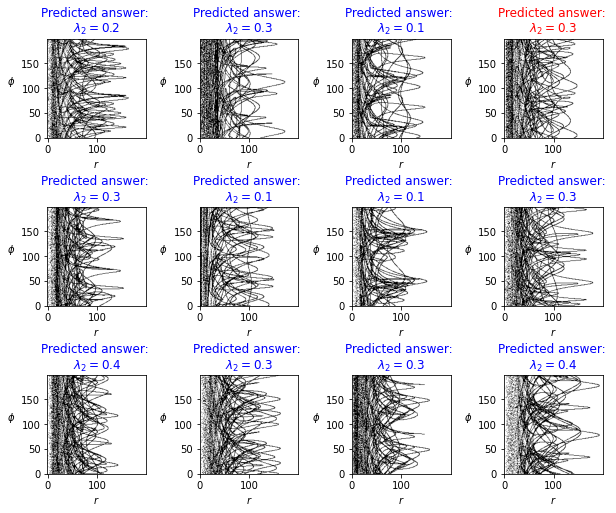

In [23]:
# calculate the prediction for test data
y_pred_one_hot = model.predict(x_test)
max_pred_index = np.argmax(y_pred_one_hot, axis=1)
max_test_index = np.argmax(y_test, axis=1)

# showing some images with prediction values.
num_rows = 3
num_cols = 4
plt.figure(figsize=(10,8))
plt.subplots_adjust( wspace = 0.5,hspace=0.7)
k = 0
plot_index = 1
for i in range(num_rows):
  for j in range(num_cols):
    plt.subplot(num_rows,num_cols,plot_index)
    plt.xlabel(r"$r$")
    plt.ylabel(r"$\phi$",rotation = "horizontal",labelpad=10)
    plt.imshow(x_test[k].reshape(200,200),cmap=plt.cm.gray_r,origin = "lower") 
    if max_pred_index[k] == max_test_index[k]:
      title_color = "blue"
    else:
      title_color = "red"
    plt.title(f"Predicted answer: \n"r"$\lambda_2 = $"f"{round(0.1* (max_pred_index[k]+1),1)}",color=title_color)
    k += 1
    plot_index += 1